In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.backend import clear_session
import gc

In [5]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [6]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "support_right", "support_left"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [7]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [8]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [9]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [11]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [12]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()

#y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
#y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))
"""
y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [13]:
logdir = "logs/Deformation/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [14]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(1024, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(64, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [15]:
model = Model(inputs=input_layer, outputs=output_layer)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,025 (316.50 KB)

 Trainable params: 81,025 (316.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mse',
              metrics=["R2Score"])

In [18]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_allowable_deformation,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - R2Score: 0.5320 - loss: 0.4118 - val_R2Score: 0.9019 - val_loss: 0.0943
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - R2Score: 0.8885 - loss: 0.1147 - val_R2Score: 0.9408 - val_loss: 0.0568
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - R2Score: 0.9267 - loss: 0.0737 - val_R2Score: 0.9476 - val_loss: 0.0504
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9330 - loss: 0.0648 - val_R2Score: 0.9558 - val_loss: 0.0425
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9385 - loss: 0.0553 - val_R2Score: 0.9538 - val_loss: 0.0444
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.9414 - loss: 0.0519 - val_R2Score: 0.9571 - val_loss: 0.0412
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9440 - loss: 0.0625 - val_R2Score: 0.9351 - val_loss: 0.0624
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9505 - loss: 0.0533 - val_R2Score: 0.9616 - 

In [19]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_allowable_deformation)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: 0.9667 - loss: 0.0300
Test accuracy: 0.9730513095855713


In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,077 (949.52 KB)

 Trainable params: 81,025 (316.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 162,052 (633.02 KB)

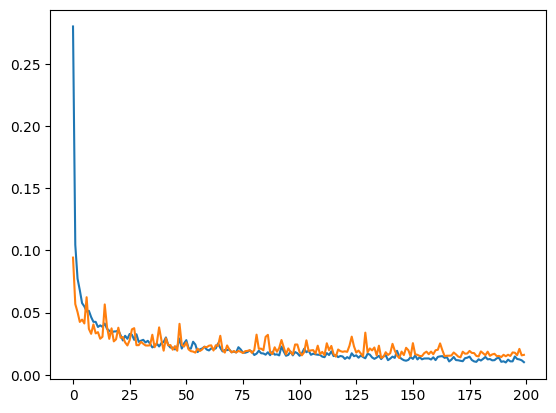

In [21]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [22]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_allowable_deformation.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [23]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df)


Sample Predictions:


               0
0       9.696914
1      85.696587
2      37.580456
3      15.736007
4       3.327323
...          ...
2453    0.832431
2454   24.505899
2455   13.720681
2456    2.316085
2457  535.927734

[2458 rows x 1 columns]


In [24]:
y_test["allowable_deformation"]

524        8.270
4546      84.443
6971      44.553
10243     15.073
7978       2.980
          ...   
8768       1.148
9224      22.090
10168     13.877
8959       1.573
3188     736.584
Name: allowable_deformation, Length: 2458, dtype: float64

In [25]:
true= y_test["allowable_deformation"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

170.29889865815542

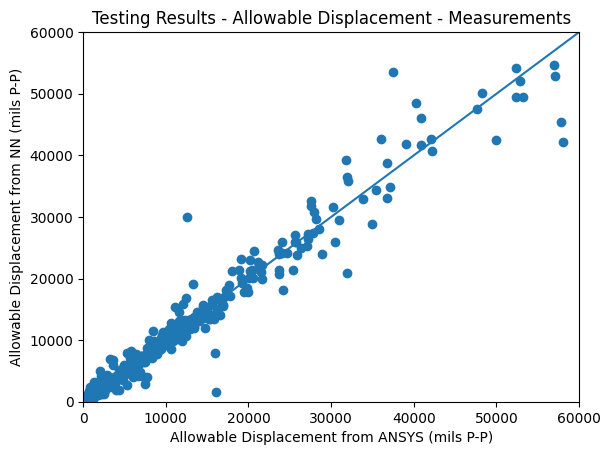

In [26]:
pred=predictions_df/0.0254*2
ansys=y_test["allowable_deformation"]/0.0254*2
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 60000],[0, 60000])
plt.xlim(0,60000)
plt.ylim(0,60000)
plt.xlabel("Allowable Displacement from ANSYS (mils P-P)")
plt.ylabel("Allowable Displacement from NN (mils P-P)")
plt.title("Testing Results - Allowable Displacement - Measurements")
plt.show()

In [27]:
clear_session()
del model
gc.collect()

0